# Drum MIDI Pattern Research

In [9]:
!pip install pretty_midi matplotlib numpy pandas

In [42]:
import pretty_midi
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
plt.style.use('ggplot')

In [88]:
import mido
import os

### Roland TD-11 mapping
https://magenta.tensorflow.org/datasets/groove#midi-data

| Pitch | Roland Mapping       | GM Mapping         | Paper Mapping       | Frequency |
|-------|----------------------|--------------------|---------------------|-----------|
| 36    | Kick                | Bass Drum 1       | Bass (36)          | 88067     |
| 38    | Snare (Head)        | Acoustic Snare    | Snare (38)         | 102787    |
| 40    | Snare (Rim)         | Electric Snare    | Snare (38)         | 22262     |
| 37    | Snare X-Stick       | Side Stick        | Snare (38)         | 9696      |
| 48    | Tom 1               | Hi-Mid Tom        | High Tom (50)      | 13145     |
| 50    | Tom 1 (Rim)         | High Tom          | High Tom (50)      | 1561      |
| 45    | Tom 2               | Low Tom           | Low-Mid Tom (47)   | 3935      |
| 47    | Tom 2 (Rim)         | Low-Mid Tom       | Low-Mid Tom (47)   | 1322      |
| 43    | Tom 3 (Head)        | High Floor Tom    | High Floor Tom (43)| 11260     |
| 58    | Tom 3 (Rim)         | Vibraslap         | High Floor Tom (43)| 1003      |
| 46    | HH Open (Bow)       | Open Hi-Hat       | Open Hi-Hat (46)   | 3905      |
| 26    | HH Open (Edge)      | N/A               | Open Hi-Hat (46)   | 10243     |
| 42    | HH Closed (Bow)     | Closed Hi-Hat     | Closed Hi-Hat (42) | 31691     |
| 22    | HH Closed (Edge)    | N/A               | Closed Hi-Hat (42) | 34764     |
| 44    | HH Pedal            | Pedal Hi-Hat      | Closed Hi-Hat (42) | 52343     |
| 49    | Crash 1 (Bow)       | Crash Cymbal 1    | Crash Cymbal (49)  | 720       |
| 55    | Crash 1 (Edge)      | Splash Cymbal     | Crash Cymbal (49)  | 5567      |
| 57    | Crash 2 (Bow)       | Crash Cymbal 2    | Crash Cymbal (49)  | 1832      |
| 52    | Crash 2 (Edge)      | Chinese Cymbal    | Crash Cymbal (49)  | 1046      |
| 51    | Ride (Bow)          | Ride Cymbal 1     | Ride Cymbal (51)   | 43847     |
| 59    | Ride (Edge)         | Ride Cymbal 2     | Ride Cymbal (51)   | 2220      |
| 53    | Ride (Bell)         | Ride Bell         | Ride Cymbal (51)   | 5567      |

In [84]:
ROLAND_TD11_MAPPING = {
    36: "Kick",
    38: "Snare (Head)",
    40: "Snare (Rim)",
    37: "Snare X-Stick",
    48: "Tom 1",
    50: "Tom 1 (Rim)",
    45: "Tom 2",
    47: "Tom 2 (Rim)",
    43: "Tom 3 (Head)",
    58: "Tom 3 (Rim)",
    46: "HH Open (Bow)",
    26: "HH Open (Edge)",
    42: "HH Closed (Bow)",
    22: "HH Closed (Edge)",
    44: "HH Pedal",
    49: "Crash 1 (Bow)",
    55: "Crash 1 (Edge)",
    57: "Crash 2 (Bow)",
    52: "Crash 2 (Edge)",
    51: "Ride (Bow)",
    59: "Ride (Edge)",
    53: "Ride (Bell)"
}

In [85]:
# map midi notes to drum names
def map_midi_to_drum(pitch):
    return ROLAND_TD11_MAPPING.get(pitch, "Unknown")

In [86]:
#load midi file
midi_file_path = "groove 2/drummer1/session1/1_funk_80_beat_4-4.mid"
midi_data = pretty_midi.PrettyMIDI(midi_file_path)

In [62]:
# analyse tempo
tempo_changes = midi_data.get_tempo_changes()
if len(tempo_changes[1]) > 0:
    bpm = tempo_changes[1][0]
else:
    bpm = 120  #default BPM

print(f"BPM: {bpm}")

BPM: 80.0


In [63]:
# get drum track
for instrument in midi_data.instruments:
    if instrument.is_drum:
        drum_track = instrument
        break

# extract note events
drum_hits = [(note.start, note.pitch, map_midi_to_drum(note.pitch)) for note in drum_track.notes]
drum_hits = sorted(drum_hits, key=lambda x: x[0])

time_stamps, pitches, drum_names = zip(*drum_hits)
time_stamps = np.array(time_stamps)

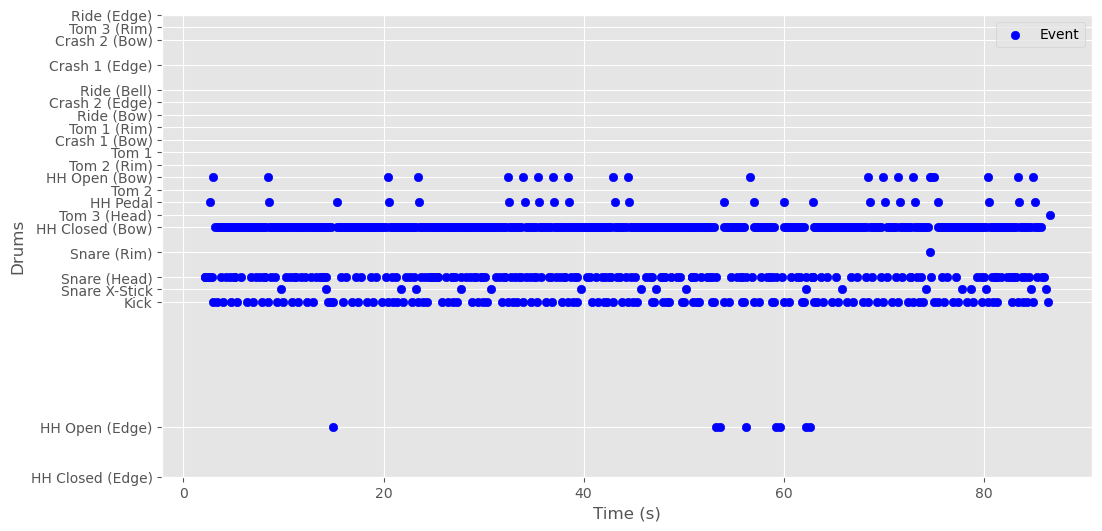

In [73]:
#plot pattern
plt.figure(figsize=(12, 6))
plt.scatter(time_stamps, pitches, marker='o', color='b', label='Event')

# axis and ticks
plt.yticks(ticks=list(ROLAND_TD11_MAPPING.keys()), labels=[map_midi_to_drum(p) for p in ROLAND_TD11_MAPPING.keys()])
plt.xlabel("Time (s)")
plt.ylabel("Drums")
plt.legend()
plt.show()

### plot drum pattern in blocks

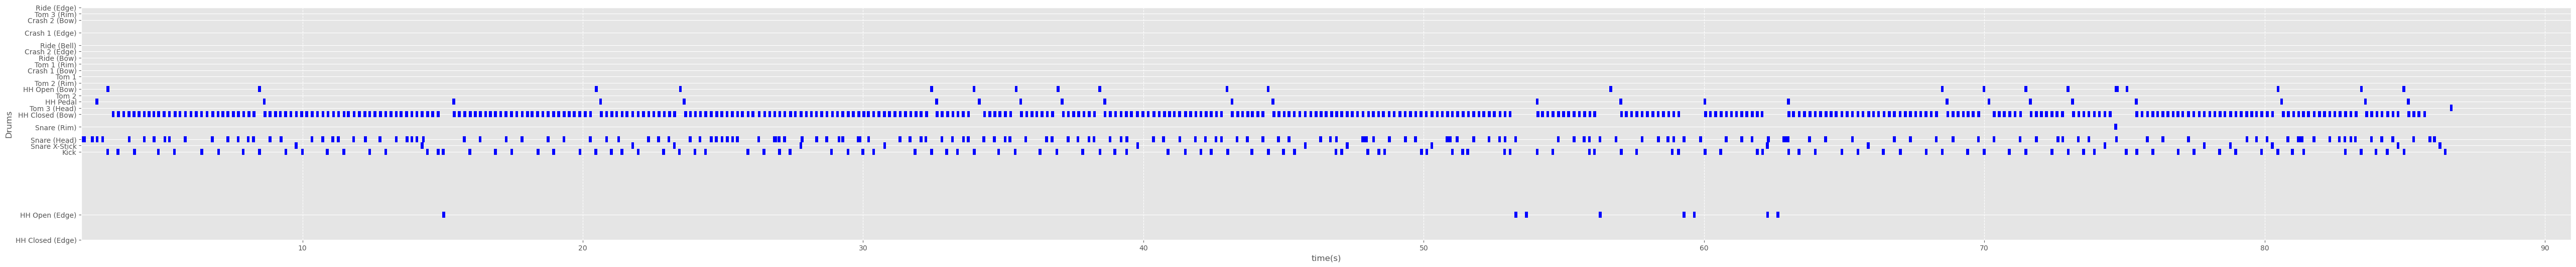

In [77]:
plt.figure(figsize=(64, 6))
for t, p in zip(time_stamps, pitches):
    plt.barh(p, width=0.1, left=t, height=1, color='b')

plt.yticks(ticks=list(ROLAND_TD11_MAPPING.keys()), labels=[map_midi_to_drum(p) for p in ROLAND_TD11_MAPPING.keys()])
plt.xlabel("time(s)")
plt.ylabel("Drums")
plt.grid(axis='x', linestyle='--', alpha=1)
plt.show()

### plot in bar measurements

#### 4 bars

In [78]:
# calculate the length of 4 bars
beats_per_bar = 4
bars = 4
total_beats = beats_per_bar * bars
seconds_per_beat = 60 / bpm
total_time = total_beats * seconds_per_beat

# modify timestamps to be within 4 bars
time_stamps = np.mod(time_stamps, total_time)

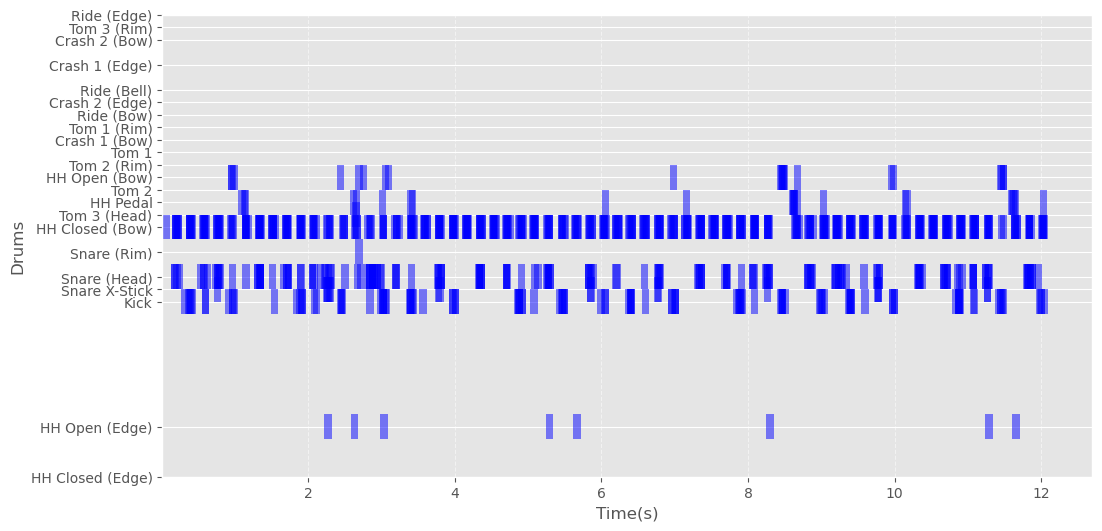

In [79]:
plt.figure(figsize=(12, 6))
for t, p in zip(time_stamps, pitches):
    plt.barh(p, width=0.1, left=t, height=2, color='b', alpha=0.5)

plt.yticks(ticks=list(ROLAND_TD11_MAPPING.keys()), labels=[map_midi_to_drum(p) for p in ROLAND_TD11_MAPPING.keys()])
plt.xlabel("Time(s)")
plt.ylabel("Drums")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

# Reconstruct drum pattern
def reconstruct_drum_pattern(drum_hits, bpm, midi_out_path="reconstructed_drum.mid"):
    new_midi = pretty_midi.PrettyMIDI()
    drum_instrument = pretty_midi.Instrument(program=0, is_drum=True)
    
    for start_time, pitch, _ in drum_hits:
        note = pretty_midi.Note(velocity=100, pitch=pitch, start=start_time, end=start_time+0.1)
        drum_instrument.notes.append(note)
    
    new_midi.instruments.append(drum_instrument)
    new_midi.write(midi_out_path)
    print(f"Reconstructed MIDI saved to {midi_out_path}")


#### 1 bar

In [80]:
beats_per_bar = 4
bars = 1
total_beats = beats_per_bar * bars
seconds_per_beat = 60 / bpm
total_time = total_beats * seconds_per_beat
# timestamps
time_stamps = np.mod(time_stamps, total_time) / seconds_per_beat

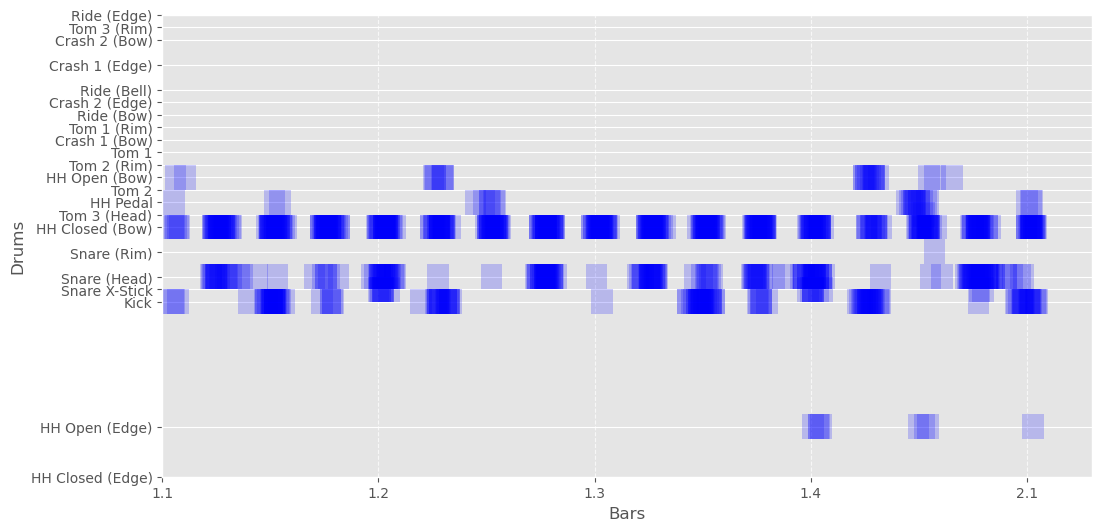

In [81]:
plt.figure(figsize=(12, 6))
for t, p in zip(time_stamps, pitches):
    plt.barh(p, width=0.1, left=t, height=2, color='b', alpha=0.2)

x_ticks = np.arange(0, total_beats + 1, 1)
x_labels = [f"{int(x//beats_per_bar)+1}.{int(x%beats_per_bar)+1}" for x in x_ticks]
plt.xticks(ticks=x_ticks, labels=x_labels)
plt.yticks(ticks=list(ROLAND_TD11_MAPPING.keys()), labels=[map_midi_to_drum(p) for p in ROLAND_TD11_MAPPING.keys()])

plt.xlabel("Bars")
plt.ylabel("Drums")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [108]:
folder_path = "groove 2/drummer1/session1/"

In [125]:
def process_midi_folder(folder_path):
    midi_files = [f for f in os.listdir(folder_path) if f.endswith(".mid")][:200]  # 200 files
    num_files = len(midi_files)
    rows =num_files // 4  # 3 diagrams per row
    
    fig, axes = plt.subplots(rows, 4, figsize=(40, 8 * rows))
    axes = axes.flatten()
    
    for i, midi_file in enumerate(midi_files):
        midi_path = os.path.join(folder_path, midi_file)
        midi_data = pretty_midi.PrettyMIDI(midi_path)
        tempo_changes = midi_data.get_tempo_changes()
        if len(tempo_changes[1]) > 0:
            bpm = tempo_changes[1][0]  #BPM
        else:
            bpm = 120  #default BPM
        drum_track = None
        for instrument in midi_data.instruments:
            if instrument.is_drum:
                drum_track = instrument
                break

        if drum_track is None:
            continue

        # note events with drum names
        drum_hits = [(note.start, note.pitch, map_midi_to_drum(note.pitch)) for note in drum_track.notes]
        drum_hits = sorted(drum_hits, key=lambda x: x[0])
        time_stamps, pitches, drum_names = zip(*drum_hits)
        time_stamps = np.array(time_stamps)

        # length of bar pattern
        beats_per_bar = 4
        bars = 1
        total_beats = beats_per_bar * bars
        seconds_per_beat = 60 / bpm
        total_time = total_beats * seconds_per_beat

        # normalize timestamps
        time_stamps = np.mod(time_stamps, total_time) / seconds_per_beat

        # plot
        ax = axes[i]
        for t, p in zip(time_stamps, pitches):
            ax.barh(p, width=0.06, left=t, height=0.5, color='b', alpha=0.5)

        x_ticks = np.arange(0, total_beats + 1, 1)
        x_labels = [f"{int(x//beats_per_bar)+1}.{int(x%beats_per_bar)+1}" for x in x_ticks]
        ax.set_xticks(x_ticks)
        ax.set_xticklabels(x_labels)
        ax.set_yticks(list(ROLAND_TD11_MAPPING.keys()))
        ax.set_yticklabels([map_midi_to_drum(p) for p in ROLAND_TD11_MAPPING.keys()])
        
        ax.set_xlabel("Bars")
        ax.set_ylabel("Drums")
        ax.set_title(midi_file)
        ax.grid(axis='x', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()


In [126]:
process_midi_folder(folder_path)